# QCoDeS QtPlot tutorial 
This notebook was made to accompany the QCoDeS tutorial and show some more advanced plotting functionality.

### The first cells here are almost the same as in the tutorial notebook
Thus all comments are removed for readability

## Import desired modules (including qcodes as qc) 
### It is important to use Qt as the gui system

In [1]:
# it is important to use Qt as the gui system
%gui qt

from pprint import pprint
import time
import numpy as np


import qcodes as qc

qc.set_mp_method('spawn')  # force Windows behavior on mac
qc.show_subprocess_widget()

<IPython.core.display.Javascript object>

## Instantiates all the instruments needed for the demo

In [2]:
from toymodel import AModel, MockGates, MockSource, MockMeter, AverageGetter, AverageAndRaw

model = AModel()
gates = MockGates('gates', model=model)
source = MockSource('source', model=model)
meter = MockMeter('meter', model=model)

station = qc.Station(gates, source, meter)

c0, c1, c2, vsd = gates.chan0, gates.chan1, gates.chan2, source.amplitude

### The location provider can be set globally 

In [3]:
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

# Running an experiment 

In [4]:
data = qc.Loop(c0.sweep(-20,20,0.1), delay=0.003).each(meter.amplitude).run(name='testsweep')


DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-07-29/#078_testsweep_19-55-58'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | gates_chan0_set | chan0        | (401,)
   Measured | meter_amplitude | amplitude    | (401,)
started at 2016-07-29 19:55:58


## Plotting the loop 
Because the dataset contains all the required meta-data plotting is trivial.  
I consider it good practice to reuse the plot monitor but that's a personal style thing. 


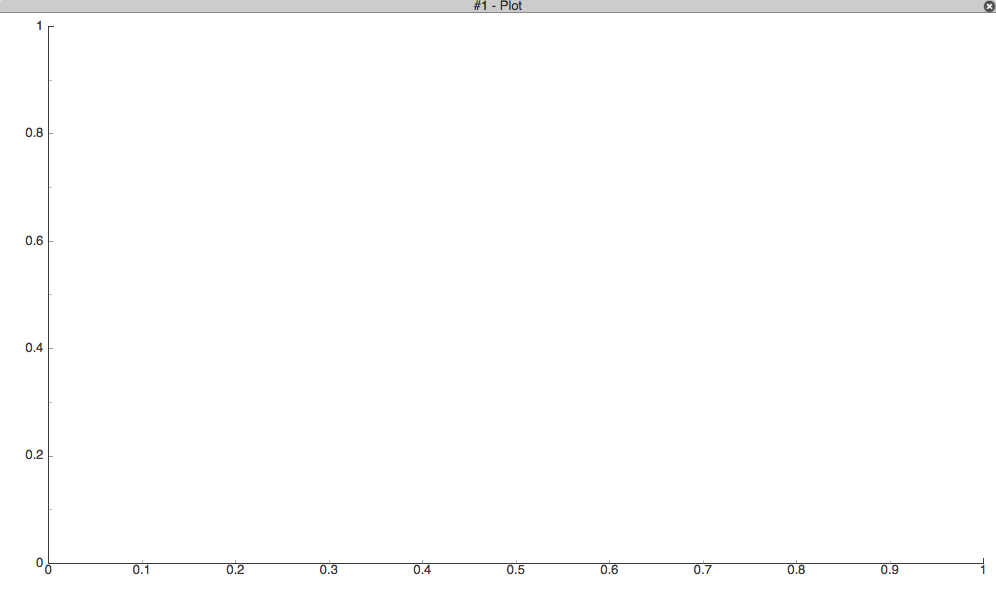

In [5]:
# A new plot-window is created, and contains an empty dock
plotQ = qc.QtPlot()

# The plot-window has a PNG representation, thus the folowing line grabs a "screenshot" of the window:
plotQ

In [6]:
# We can add data to the plot-window, which will automatically add data to the first subplot (dock):
subplot1 = plotQ.add(data.meter_amplitude)

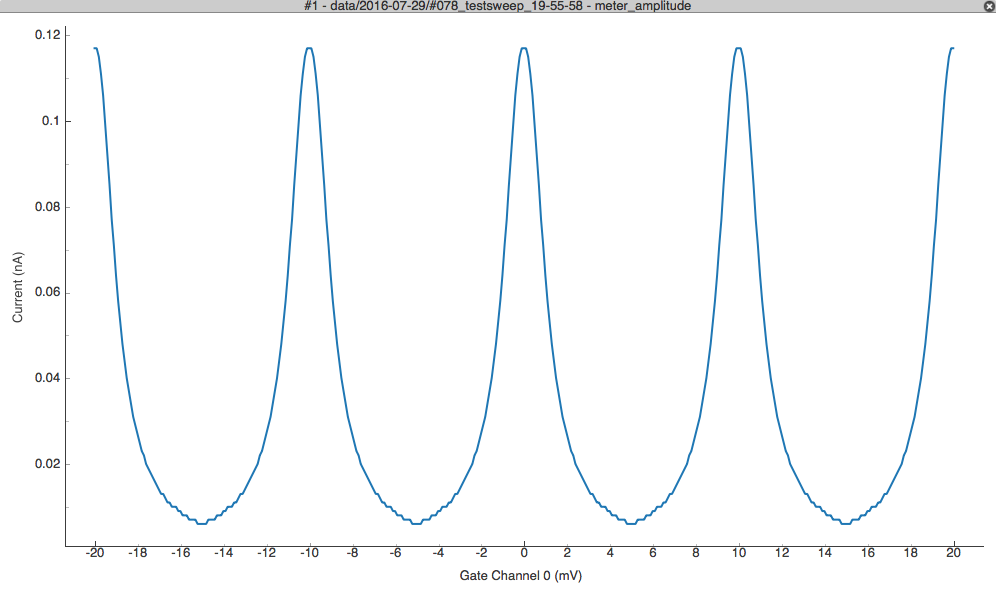

In [7]:
# Also the subplot has a PNG representation, but the screenshot will be taken immideately,
# which shows an incomplete plot while live-plotting is active.
# So we excecute this after the live plot has finished
subplot1

## Example: multiple 2D measurements 

In [8]:
data2 = qc.Loop(c1[-15:15:1], 0.01).loop(c0[-15:10:.5], 0.001).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    qc.Task(c2.set, 1), # action 1 -> c2.set(1)
    qc.Wait(0.001),
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    qc.Task(c2.set, 0)
    ).run(name='2D_test')

# the equivalent in QtPlot
# by clearing the old window it can be reused
plotQ.clear() 
s1 = plotQ.add(data2.meter_amplitude_0, figsize=(1200, 500))
s2 = plotQ.add(data2.meter_amplitude_3, subplot=2)          

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-07-29/#079_2D_test_19-56-05'
   <Type>   | <array_id>        | <array.name> | <array.shape>
   Setpoint | gates_chan1_set   | chan1        | (30,)
   Setpoint | gates_chan0_set   | chan0        | (30, 50)
   Measured | meter_amplitude_0 | amplitude    | (30, 50)
   Measured | meter_amplitude_3 | amplitude    | (30, 50)
started at 2016-07-29 19:56:05


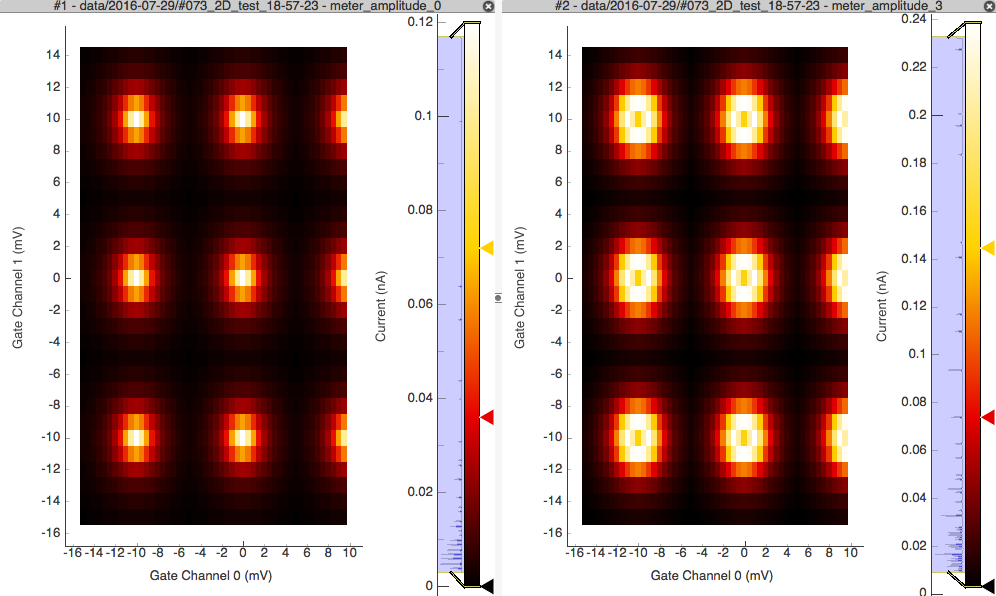

In [17]:
# After the plot has finished, we show it in the notebook
plotQ

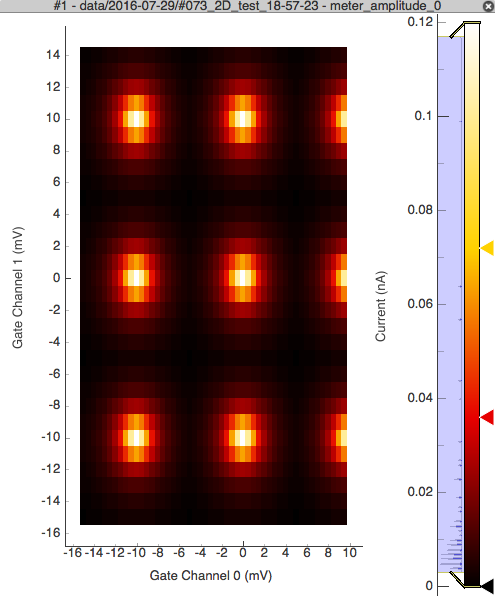

In [18]:
# or we show only a single subplot:
s1

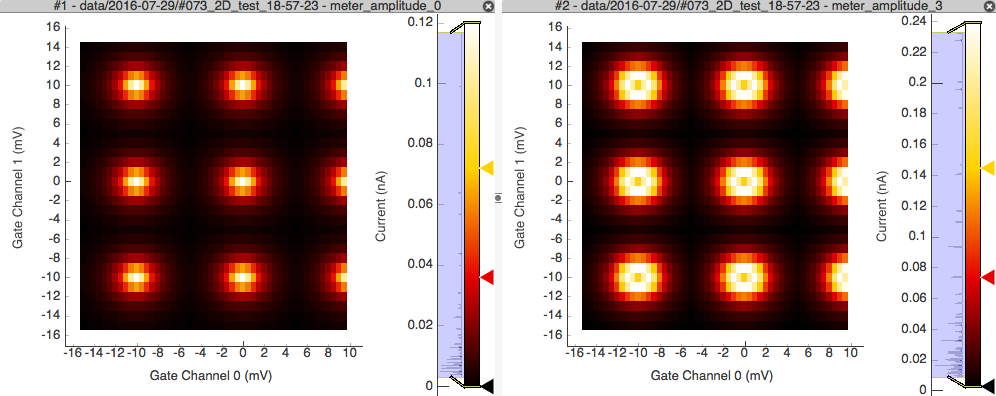

In [19]:
plotQ.resize(1000,400)
plotQ

In [20]:
# We can switch x and y axes:
plotQ.clear() 
s1 = plotQ.add(data2.meter_amplitude_0, figsize=(1200, 500))
s2 = plotQ.add(data2.meter_amplitude_0, subplot=2, transpose=True)

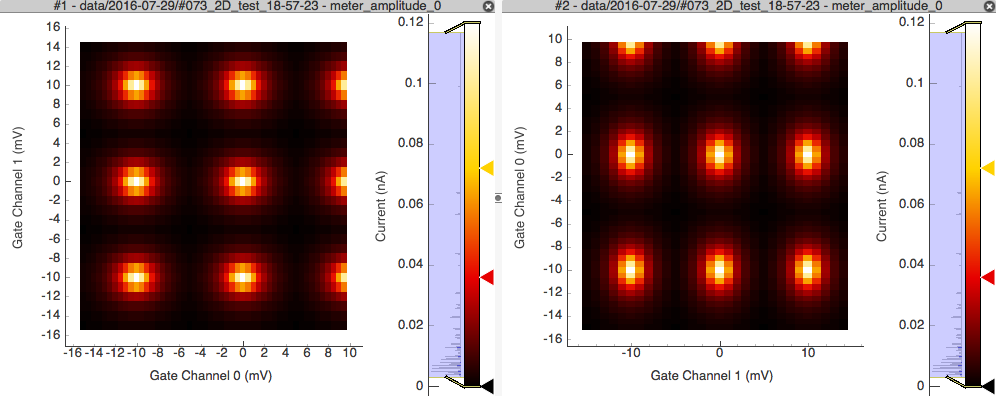

In [21]:
plotQ

In [22]:
# We can switch x and y axes, change labels, titles:
plotQ.clear() 
s1 = plotQ.add(data2.meter_amplitude_0, figsize=(1200, 500), title='First dataset')
s2 = plotQ.add(data2.meter_amplitude_0, subplot=2, transpose=True, xlabel='rainbowness')

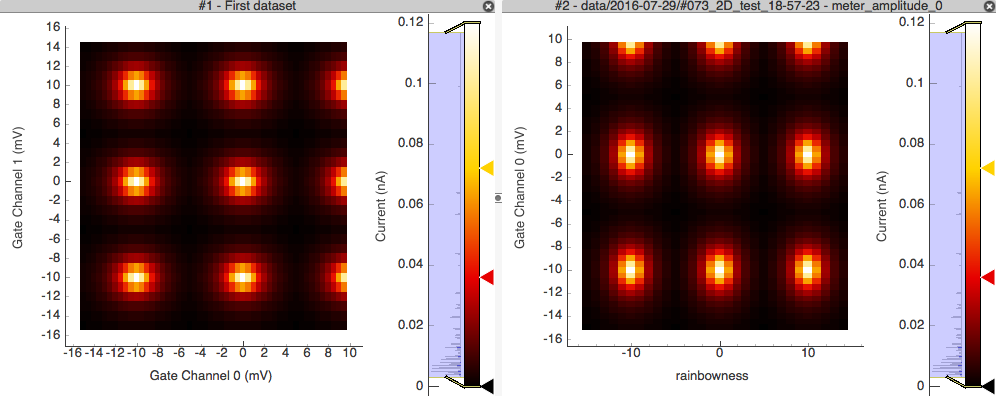

In [23]:
plotQ

In [53]:
# We can position sub-plots relative to eachother
plotQ.clear()
s1 = plotQ.add(data2.meter_amplitude_0)
# Bottom of the window
s2 = plotQ.add(data2.meter_amplitude_0, subplot=-1, position='bottom')
# right side of the window
s3 = plotQ.add(data2.meter_amplitude_0, subplot=-1, position='right')
# left side of another subplot
s4 = plotQ.add(data2.meter_amplitude_0, subplot=-1, position='left', relativeto=s1)
# Note the "#n" in the beginning of dock titles, those are the subplot numbers
# bottom side of another subplot, this time referenced by the index
s5 = plotQ.add(data2.meter_amplitude_0, subplot=-1, position='bottom', relativeto=3)


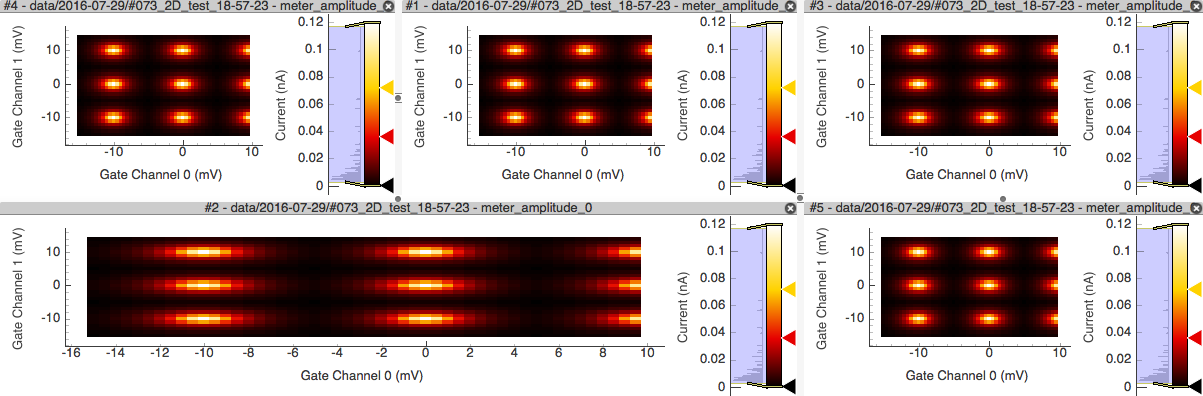

In [54]:
plotQ

In [56]:
# Also tabbed plots are possible
s6 = plotQ.add(data2.meter_amplitude_0, subplot=-1, position='below', relativeto=s2)


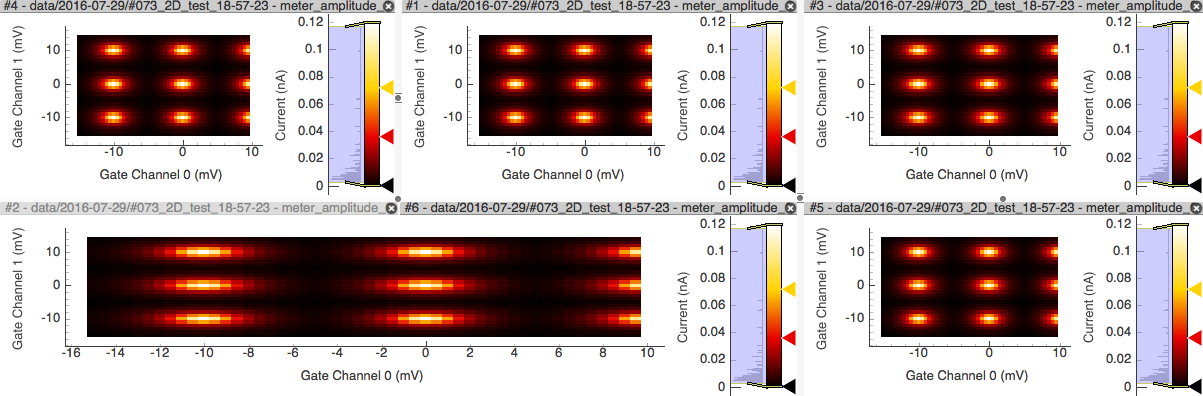

In [57]:
plotQ

## Example same outer loop, different inner loop 

In [61]:
data3 = qc.Loop(c1[-15:15:1], 0.1).each(
    qc.Task(c0.set, -10),
    qc.Task(c2.set, 0),
    # a 1D measurement
    meter.amplitude,
    # a 2D sweep, .each is actually unnecessary bcs this is the default measurement
    qc.Loop(c0[-15:15:1], 0.001).each(meter.amplitude),
    qc.Task(c0.set, -10),
    # a 2D sweep with the same outer but different inner loop
    qc.Loop(c2[-10:10:0.2], 0.001).each(meter.amplitude),
    AverageGetter(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(name='TwoD_different_inner_test')

# several plots updating simultaneously
# plot3 = qc.MatPlot(data3.meter_amplitude_3_0, cmap=plt.cm.hot)
# plot3b = qc.MatPlot(data3.meter_amplitude_5_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1,2))
# plot3b.add(data3.meter_avg_amplitude, subplot=2)
plotQ.clear()
plotQ.add(data3.meter_amplitude_3_0)
plotQ.add(data3.meter_amplitude_5_0, cmap='viridis', subplot=2)
plotQ.add(data3.meter_avg_amplitude, subplot=3)
'' # to suppress the empty plot representation in the notebook

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-07-29/#076_TwoD_different_inner_test_19-01-27'
   <Type>   | <array_id>          | <array.name>  | <array.shape>
   Setpoint | gates_chan1_set     | chan1         | (30,)
   Measured | meter_amplitude_2   | amplitude     | (30,)
   Setpoint | gates_chan0_set     | chan0         | (30, 30)
   Measured | meter_amplitude_3_0 | amplitude     | (30, 30)
   Setpoint | gates_chan2_set     | chan2         | (30, 100)
   Measured | meter_amplitude_5_0 | amplitude     | (30, 100)
   Measured | meter_avg_amplitude | avg_amplitude | (30,)
started at 2016-07-29 19:01:27


''

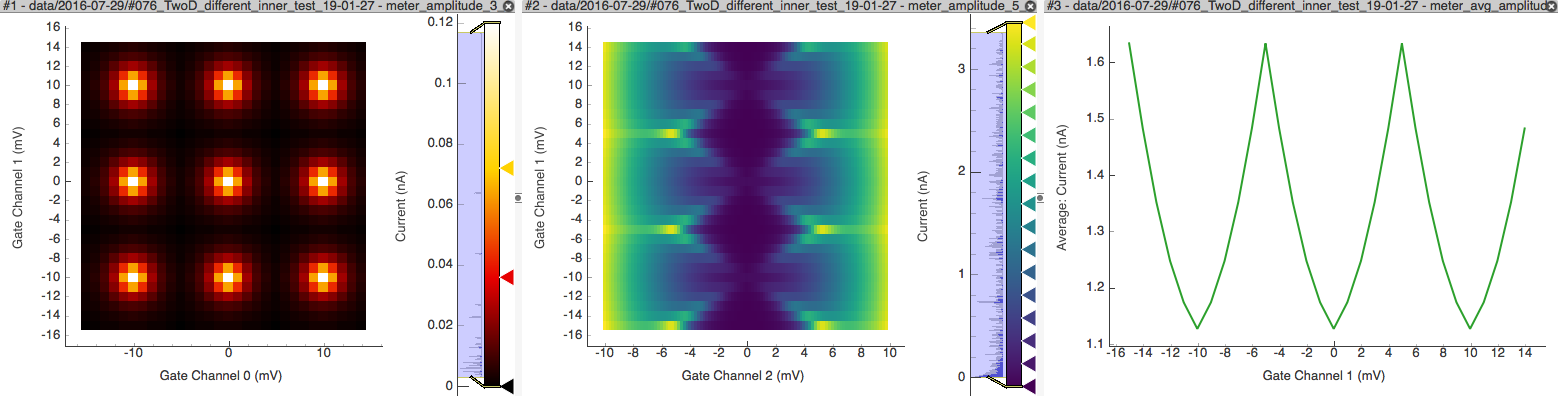

In [62]:
plotQ

### Example 2D scan and average

In [63]:
# An example of a parameter that returns several values of different dimension
# This produces the last two arrays from data3, but only takes the data once.
data4 = qc.Loop(c1[-15:15:1], 0.01).each(
    AverageAndRaw(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(name='TwoD_average_test')

# plot4 = qc.MatPlot(data4.meter_amplitude, cmap=plt.cm.hot, subplots=(1,2), figsize=(12, 4.5))
# plot4.add(data4.meter_avg_amplitude, subplot=2)

plotQ.clear()
plotQ.add(data4.meter_amplitude, figsize=(1200, 500), cmap='viridis')
plotQ.add(data4.meter_avg_amplitude, subplot=2)
'' # to suppress the empty plot representation in the notebook

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-07-29/#077_TwoD_average_test_19-02-11'
   <Type>   | <array_id>          | <array.name>  | <array.shape>
   Setpoint | gates_chan1_set     | chan1         | (30,)
   Measured | chan2               | chan2         | (30, 100)
   Measured | meter_amplitude     | amplitude     | (30, 100)
   Measured | meter_avg_amplitude | avg_amplitude | (30,)
started at 2016-07-29 19:02:12


''

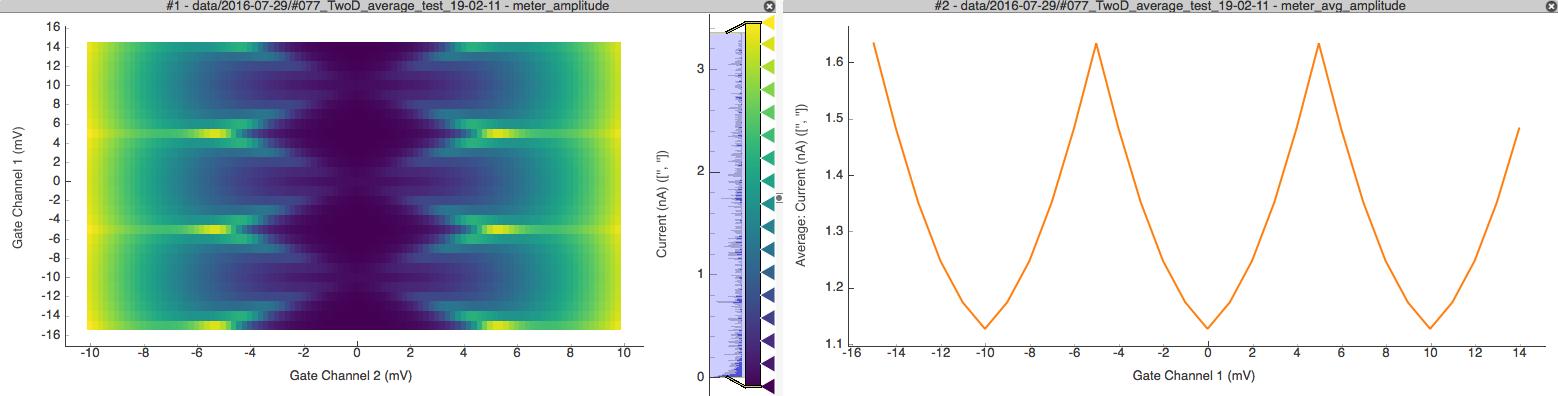

In [64]:
plotQ

# Data analysis, loading old data 

`DataSet` objects are not intended to be instantiated directly, but
rather through the helper functions:
- `load_data` for existing data sets, including the data currently
  being acquired.
- `new_data` to make an empty data set to be populated with new
  measurements or simulation data. `new_data` is called internally by
  `Loop.run()` so is also generally not needed directly.

If you omit `location`, or if `location` matches the data set currently
being acquired, `load_data` and subsequent calls to `data_set.sync()`
will pull from the `DataServer` (`DataMode.PULL_FROM_SERVER`).
Otherwise `load_data` and `data_set.sync()` will read from disk
(`DataMode.LOCAL`).

Note that a `DataServer` is, at least for now, local to one parent
process / notebook, so if you open a separate notebook for analysis, even
your live data will be pulled from disk.

In [65]:
# Use the location of a file created earlier this session
location = data3.location 
print(location)
data = qc.load_data(location=location)

data/2016-07-29/#076_TwoD_different_inner_test_19-01-27


In [66]:
data

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-07-29/#076_TwoD_different_inner_test_19-01-27'
   <Type>   | <array_id>          | <array.name>  | <array.shape>
   Setpoint | gates_chan0_set     | chan0         | (30, 30)
   Measured | meter_amplitude_3_0 | amplitude     | (30, 30)
   Measured | meter_amplitude_2   | amplitude     | (30,)
   Setpoint | gates_chan1_set     | chan1         | (30,)
   Measured | meter_avg_amplitude | avg_amplitude | (30,)
   Measured | meter_amplitude_5_0 | amplitude     | (30, 100)
   Setpoint | gates_chan2_set     | chan2         | (30, 100)

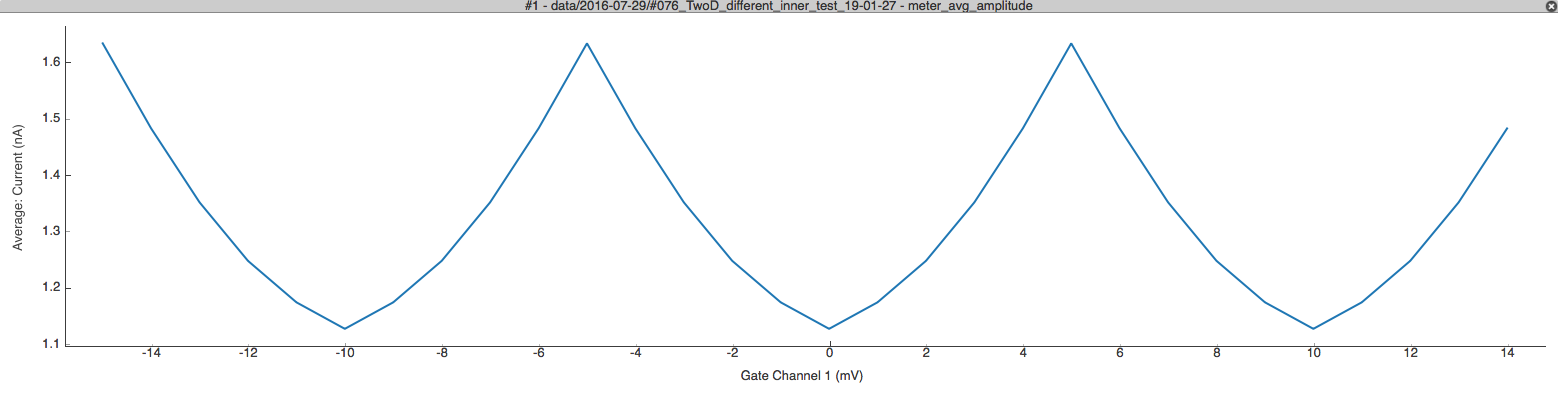

In [67]:
plotQ.clear()
plotQ.add(data.meter_avg_amplitude)